# Monte-Carlo Control Exploration Start

In [29]:
import random
import gym
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict
from functools import partial
%matplotlib inline
plt.style.use('ggplot')

In [30]:
env = gym.make('Blackjack-v1')

In [31]:
def mces_policy(observation, q_table, n_action):
    if n_action == 0: # Exploration Start
        return random.randint(0,1)
    else:
        actions_value = q_table[observation]
        try:
            action = max(actions_value, key=actions_value.get)
        except ValueError: # When the q_table is yet to be filled and thus, unable to choose the optimal policy
            action = random.randint(0,1)
        return action

In [32]:
def generate_episode(q_table, env, policy):
    
    # we initialize the list for storing states, actions, and rewards
    states, actions, rewards = [], [], []
    
    # Initialize the gym environment
    observation = env.reset()
    n_action = 0
    
    while True:
        
        # append the states to the states list
        states.append(observation)
        
        # now, we select an action using our mces_policy function and append the action to actions list
        action = policy(observation, q_table, n_action)
        actions.append(action)
        
        # We perform the action in the environment according to our sample_policy, move to the next state 
        # and receive reward
        observation, reward, done, info = env.step(action)
        rewards.append(reward)
        
        # Break if the state is a terminal state
        if done:
             break

        n_action += 1
                
    return states, actions, rewards

In [38]:
def policy_improvement(policy, env, n_episodes):
    q_table = defaultdict(lambda: defaultdict(float))
    N = defaultdict(int) # Store number of observed occurence for each state

    for _ in range(n_episodes):
        states, actions, rewards = generate_episode(q_table, env, policy)
        returns = 0

        for t in range(len(states) - 1, -1, -1):
            R = rewards[t] # Record Immediate Rewards
            A = actions[t]
            S = states[t] # Record Current State

            returns += R

            if S not in states[:t]:
                N[(S,A)] += 1
                q_table[S][A] += (returns - q_table[S][A]) / N[(S,A)]
    
    return q_table


In [46]:
q_table = policy_improvement(mces_policy, env, n_episodes=5000000)

In [47]:
value = {state: max(q_table[state].values()) for state in q_table.keys()}

In [48]:
def plot_blackjack(V, ax1, ax2):
    player_sum = np.arange(12, 21 + 1)
    dealer_show = np.arange(1, 10 + 1)
    usable_ace = np.array([False, True])
    state_values = np.zeros((len(player_sum), len(dealer_show), len(usable_ace)))

    for i, player in enumerate(player_sum):
        for j, dealer in enumerate(dealer_show):
            for k, ace in enumerate(usable_ace):
                state_values[i, j, k] = V[player, dealer, ace] # Append the valuefunc for each state available
    
    X, Y = np.meshgrid(dealer_show, player_sum)
 
    ax1.plot_wireframe(X, Y, state_values[:, :, 0])
    ax2.plot_wireframe(X, Y, state_values[:, :, 1])
 
    for ax in ax1, ax2:
        ax.set_zlim(-1, 1)
        ax.set_ylabel('player sum')
        ax.set_xlabel('dealer showing')
        ax.set_zlabel('state-value')
        

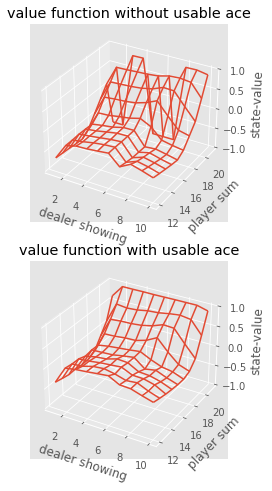

In [67]:
fig, axes = pyplot.subplots(nrows=2, figsize=(5, 8),
subplot_kw={'projection': '3d'})
axes[0].set_title('value function without usable ace')
axes[1].set_title('value function with usable ace')
plot_blackjack(value, axes[0], axes[1])

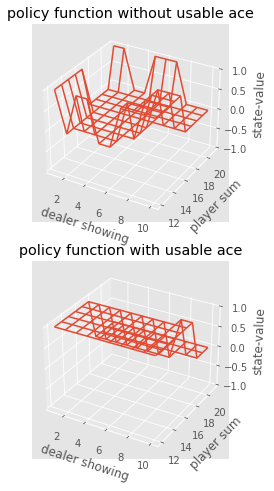

In [69]:
policy_table = {state: max(q_table[state], key=q_table[state].get) for state in q_table.keys()}
fig, axes = pyplot.subplots(nrows=2, figsize=(5, 8),
subplot_kw={'projection': '3d'})
axes[0].set_title('policy function without usable ace')
axes[1].set_title('policy function with usable ace')
plot_blackjack(policy_table, axes[0], axes[1])